In [1]:
%matplotlib widget
from __future__ import annotations
import copy
from typing import Callable, Optional
from dataclasses import dataclass
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from gaussian_utilities import eval_normpdf_on_grid, normpdf, plot_bivariate_gauss

# Bayesian Linear-Gaussian Inverse Problems: Application to Regression

Alex Gorodetsky, October 2020,2021, February 2024

Linear-Gaussian inverse problems form the most important subset of Bayesian inference problems for which an analytic solution exists. These problems can be solved by exploiting the fact that the marginal and conditional distributions of jointly distributed Gaussians are themselves Gaussian. These ideas form the fundamental basis of many existing techniques across application areas. Two applications -- Gaussian process regression and Kalman filtering are covered extensively in this class. In this notebook we first review the general solution to linear-Gaussian problems and then we apply these ideas to the regression problem.

## Linear-Gaussian Inverse Problems

Recall the setup. We want to learn a parameter $\theta \in \mathbb{R}^p$. We obtain data $y \in \mathbb{R}^m$, and the noise model is linear with Gaussian noise

\begin{equation}
Y = A \theta + \xi, \quad \xi \sim \mathcal{N}(0, \Gamma)
\end{equation}

This noise model implies a Gaussian sampling distribution $Y\mid \theta \sim \mathcal{N}(A\theta, \Gamma)$. (The symbol "~" means "distributed according to"). 

Next, the Bayesian approach to linear-Gaussian inverse problem assumes a Gaussian prior $\theta \sim \mathcal{N}(\mu, \Sigma)$. Immediately this distribution implies the following facts

1. $Y \sim \mathcal{N}\left(A\mu, A\Sigma A^T + \Gamma\right)$

2. $\mathbb{C}\text{ov}(Y, \theta) = \mathbb{C}\text{ov}(A\theta + \xi, \theta) = A\mathbb{C}\text{ov}(\theta, \theta) = A\Sigma$

3. The joint distribution of $\theta$ and $Y$ is Gaussian:

\begin{equation}
(\theta, Y) \sim \mathcal{N}\left( 
\begin{bmatrix}
\mu \\
A\mu
\end{bmatrix},
\begin{bmatrix}
\Sigma & \Sigma A^T \\
A \Sigma  & A\Sigma A^T + \Gamma
\end{bmatrix}
\right)
\end{equation}

4. Finally, the equations for conditioning Gaussians provides the posterior $\theta \mid Y=y \sim \mathcal{N}(\mu_{p}, \Sigma_{p})$ where we provide two (of many) equivalent expressions for the mean and covariance

\begin{align}
\mu_p &= \mu + \Sigma A^T\left(A\Sigma A^T + \Gamma\right)^{-1}\left(y - A\mu\right) = \left(A^T \Gamma^{-1} A + \Sigma^{-1}\right)^{-1}\left(A^T\Gamma^{-1}y + \Sigma^{-1}\mu\right) \\
\Sigma_p &= \Sigma - \Sigma A^T \left(A\Sigma A^T + \Gamma\right)^{-1} A \Sigma = \left(A^T \Gamma^{-1}A + \Sigma^{-1}\right)^{-1}
\end{align}

These last equations are so important, I *almost* recommend you commit them to memory. At the very least please write them down on the flashcard along with the 7 properties of expectations and variances. These equations, those 7 properties, and the rules of probability (2-3) are 10 equations from which everything can be determined. 

These two equations are very intuitive --- they show how the data is used to "correct" the mean and how the posterior covaraince is "smaller" than the prior covariance. Interestingly note that the posterior covariance is not a function of the data! In the notes we also showed how these equations can show that the posterior mean is a convex combination of the prior and the MLE.

In [3]:
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray
    # optional additional covariance to some linearly related RV
    linear_cov: Optional[np.ndarray] = None

class LinearGaussianModel:
    """A linear Gaussian model."""

    def __init__(self, A: np.ndarray, theta: Gaussian, noise: Gaussian) -> np.ndarray:
        self.theta = theta
        self.A =  A
        self.noise = noise

    def prediction_marginal(self) -> Gaussian:
        """Compute the marginal distribution of Y = A theta + xi."""

        mean = np.dot(self.A, self.theta.mean) + self.noise.mean
        ASigma = np.dot(self.A, self.theta.cov)
        cov = np.dot(ASigma, self.A.T) + self.noise.cov

        return Gaussian(mean, cov, ASigma)

    def predict_no_noise(self) -> Gaussian:
        ASigma = np.dot(self.A, self.theta.cov)
        cov = np.dot(ASigma, self.A.T)
        return Gaussian(np.dot(self.A, self.theta.mean), cov)

    def solve_inverse_problem(self, data: np.ndarray) -> LinearGaussianModel:
        """Update the Linear Gaussian model with data.

        Args:

            data: array of observed values

        Returns:

            A new linear gaussian inverse problem, but with updated
            Gaussian as the base distribution
        """

        # Compute Marginal
        Y = self.prediction_marginal()

        # Condition
        delta = data - Y.mean
        update = np.linalg.solve(Y.cov, delta)

        # Use two Gaussian conditioning equations for the posterior mean and covariance
        post_mean = self.theta.mean + np.dot(Y.linear_cov.T, update)
        post_cov =  self.theta.cov - np.dot(Y.linear_cov.T, np.linalg.solve(Y.cov, Y.linear_cov))

        newX = Gaussian(post_mean, post_cov)
        return LinearGaussianModel(self.A, newX, self.noise)

## Application to Linear Regression

We can now have Bayesian linear regression. We just have to build the appropriate $A$ matrix. Recall that the linear model is $$Y = \theta_0 + \theta_{1:m}^T x + \xi = \theta_0 + \sum_{i=1}^m \theta_i x_i + \xi,$$ where $x = (x_1,\ldots, x_m)$ is an $m$ dimensional input

Lets again assume that we are predicting a scalar and that we have $N$ data points. We can write the noise model in matrix form

\begin{equation}
\begin{bmatrix}
Y_1 \\
Y_2 \\
\vdots \\
Y_N 
\end{bmatrix}
= 
\begin{bmatrix}
1 & x^{(1)^T} \\
1 & x^{(2)^T} \\
\vdots & \vdots \\
1 & x^{(N)^T}
\end{bmatrix}
\begin{bmatrix}
\theta_0 \\
\theta_{1} \\
\vdots \\
\theta_{m}
\end{bmatrix}
+ 
\xi \quad 
\xi \sim \mathcal{N}\left(
\begin{bmatrix}
0 \\
0 \\
\vdots \\
0
\end{bmatrix},
\begin{bmatrix}
\sigma^2 & 0 & \cdots &0 \\
0 & \sigma^2 & \ddots & \vdots \\
0 & \ddots & \ddots & \vdots \\
0 & \cdots & 0 & \sigma^2
\end{bmatrix}
\right)
\end{equation}
This is the linear Gaussian form so we can readily solve the problem. The particular A matrix here is often called a **Vandermonde** matrix

Note that I am distinguishing the samples of the inputs $x^{(i)}$ which are not random variables in this model from the outputs $Y_i$ which are. We will then consider that $Y_i = y^{(i)}$ when we consider the specific data realization, this comes during the actual inference process -- not when setting up the noise model.

In [4]:
def linear_regression(xtrain: np.ndarray,
                      ytrain: np.ndarray,
                      xpredict: Optional[np.ndarray],
                      vand_func: Callable[[np.ndarray], np.ndarray],
                      theta_prior: Gaussian,
                      noise: Gaussian) -> Tuple[LinearGaussianModel, LinearGaussianModel, Optional[LinearGaussianModel]]:
    """Perform linear regression.

    Args;
        xtrain: (N, d) training inputs
        ytrain: (N) training outputs
        xpredict: (M, d) an array of points where predictions are required (If none, then is ignored)
        theta_prior: Gaussian random variable
        vand_func: A function which builds the vandermonde matrix from the inputs
        noise: Gaussian random_variable, assumes the same for each N outputs

    Outputs:
        model_prior, model_posterior and model_predict (optional if xpredict) specified

    Notes:
        Predictions assumes no noise: just y = x^T theta
    """

    A = vand_func(xtrain)
    N = A.shape[0]

    cov_all_data = np.diag(np.ones(N) * noise.cov)
    mean_all_data = np.ones(N) * noise.mean

    model_prior = LinearGaussianModel(A, theta_prior, Gaussian(mean_all_data, cov_all_data))

    model_posterior = model_prior.solve_inverse_problem(ytrain)

    # Perform prediction: which is just computing the marginal with no noise
    if xpredict is not None:
        Apred = vand_func(xpredict)
        Npred = Apred.shape[0]

        cov_noise_pred = np.diag(np.ones(Npred) * noise.cov)
        mean_noise_pred = np.ones(Npred) * noise.mean
        model_predict =  LinearGaussianModel(Apred, model_posterior.theta,
                                             Gaussian(mean_noise_pred, cov_noise_pred))

        return model_prior, model_posterior, model_predict
    else:
        return model_prior, model_posterior, None

Lets look at a demo. Suppose I want to predict $f(x)$ for some new $x$. We write the model

\begin{equation}
f(x; \theta) = \theta_0 + \sum_{i=1}^m \theta_i x_i = A(x) \theta
\end{equation}
What is $p(f(x; \theta) | data)$? We know that $ \theta \mid data \sim \mathcal{N}(\mu_p, \Sigma_p)$

In [5]:
ndata = 10
param_true = (0.5, -0.2)
prior = Gaussian(np.array([0.0, 0.0]), np.eye(2))
noise_rv = Gaussian(0.0, 1e-1)

# generate data
xtrain = np.random.rand(ndata) * 2.0 - 1.0  # Inputs are between -1 and 1
noise = np.random.randn(ndata) * np.sqrt(noise_rv.cov)
ytrain = param_true[0] + param_true[1] * xtrain + noise

# truth and locations for prediction
x = np.linspace(-1, 1, 100)
y = param_true[0] + param_true[1] * x

# build vandermonde
def vand_linear(xin: np.ndarray) -> np.ndarray:
    N = xin.shape[0]
    A = np.ones((N, 2))
    A[:, 1] = xin
    return A

# perform inference
model_prior, model_posterior, model_predict = linear_regression(xtrain, ytrain, x, vand_linear, prior, noise_rv)

We see that the inference occurs on the last two lines (really the last line). We now visualize what is happening.
We begin by looking at the prior and posterior of the parameters

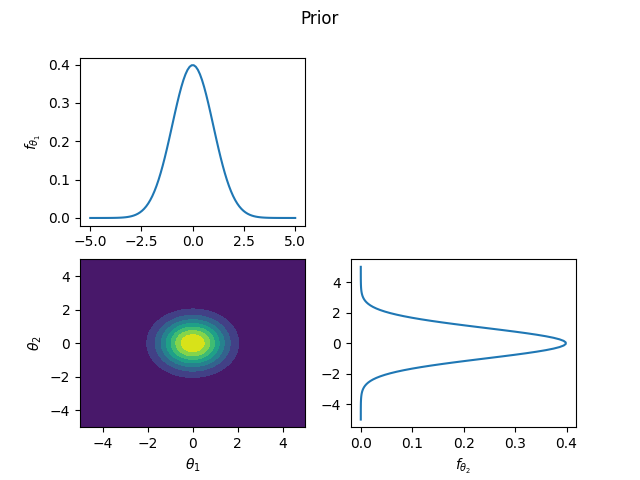

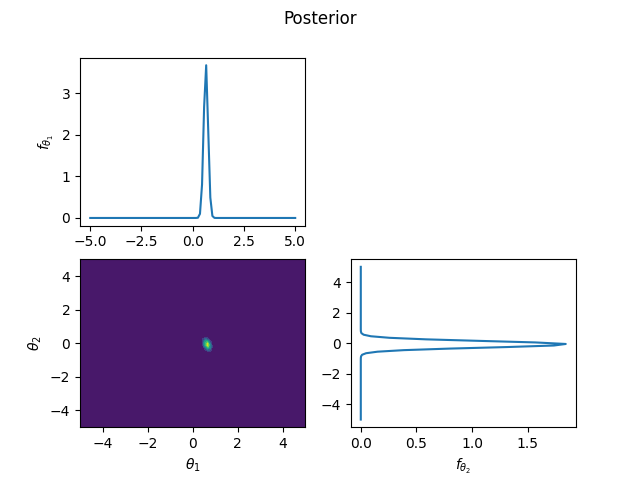

In [6]:
###############################
## Plot Prior/Posterior of the parameters
###############################
offset_range = np.linspace(-5, 5,100)
slope_range = np.linspace(-5, 5,100)

plt.close(1)
plt.figure(1)
post_theta = model_posterior.theta
figp, axsp = plot_bivariate_gauss(1, offset_range, slope_range, post_theta.mean, post_theta.cov)
plt.suptitle("Posterior")

plt.close(2)
plt.figure(2)
figp, axsp = plot_bivariate_gauss(2, offset_range, slope_range, prior.mean, prior.cov)
plt.suptitle('Prior')
plt.show()

Next lets look at the prior/posterior **predictions**. These are really what we care about in regression.  Lets first create a utility function to help with the plotting

In [7]:
def plot_function_pred(axis, model_theta, xdata, ydata, xpred, ytrue, title, nsample=40, legend=True):
    """Helper function for plotting distributions over functions and associated data"""
    pred = model_theta.predict_no_noise()
    pred_std = np.sqrt(np.diag(pred.cov))
    axis.plot(xdata, ydata, 'o', ms=8, label='data')
    axis.plot(xpred, ytrue, '-', lw=2, color='black', label='true function')
    axis.plot(xpred, pred.mean, 'r--', lw=3, label='mean')
    axis.fill_between(xpred, pred.mean - 2 * pred_std,
                             pred.mean + 2 * pred_std,
                      lw=3, label=r'2$\sigma$', color='red', alpha=0.2)
    if nsample > 0:
        sqrt_cov = np.linalg.cholesky(pred.cov + 1e-10*np.eye(xpred.shape[0]))
        samples = np.tile(pred.mean[:, np.newaxis], (1, nsample)) + np.dot(sqrt_cov, np.random.randn(xpred.shape[0], nsample))
        axis.plot(xpred, samples, '-', color='grey', alpha=0.1)
    if legend is True:
        axis.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
    axis.set_title(title, fontsize=20)

Next lets plot the prior and posterior predictives.

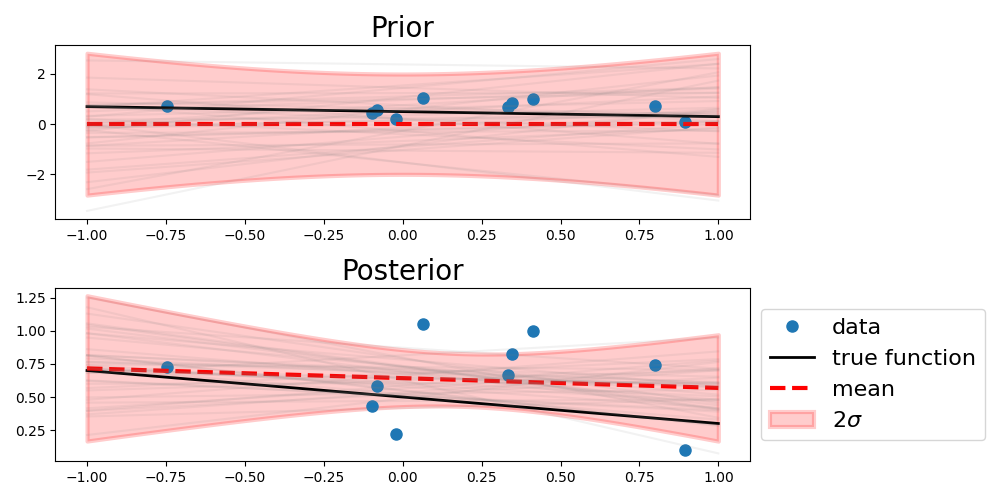

In [8]:
plt.close(3)
fig, axis = plt.subplots(2, 1, figsize=(10, 5), num=3)

model_prior_predict =  LinearGaussianModel(vand_linear(x), model_prior.theta, None)
plot_function_pred(axis[0], model_prior_predict, xtrain, ytrain, x, y, "Prior", nsample=40, legend=False)
plot_function_pred(axis[1], model_predict, xtrain, ytrain, x, y, "Posterior", nsample=40)
plt.tight_layout()

Lets plot them on the same plot to see how they shrink

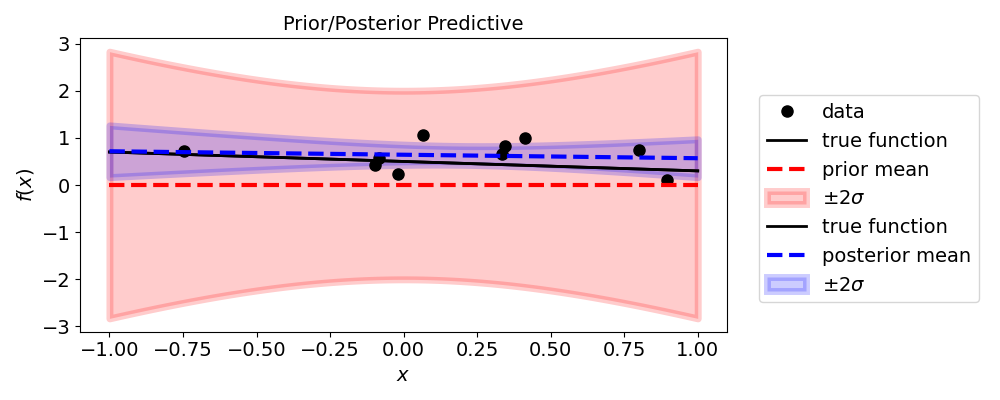

In [9]:
prior_pred = model_prior_predict.predict_no_noise()
prior_pred_std = np.sqrt(np.diag(prior_pred.cov))
post_pred = model_predict.predict_no_noise()
post_pred_std = np.sqrt(np.diag(post_pred.cov))

plt.close(4)
fig, axs = plt.subplots(1, figsize=(10, 4), num=4)
axs.plot(xtrain, ytrain, 'ko', ms=8, label='data')
axs.plot(x, y, '-', lw=2, color='black', label='true function')
axs.plot(x, prior_pred.mean, 'r--', lw=3, label='prior mean')
axs.fill_between(x,
                prior_pred.mean - 2*prior_pred_std,
                prior_pred.mean + 2*prior_pred_std,
                lw=5, label=r'$\pm 2\sigma$', color='red', alpha=0.2)

axs.plot(x, y, '-', lw=2, color='black', label='true function')
axs.plot(x, post_pred.mean, 'b--', lw=3, label='posterior mean')
axs.fill_between(x,
                 post_pred.mean - 2*post_pred_std,
                 post_pred.mean + 2*post_pred_std,
                 lw=5, label=r'$\pm 2\sigma$', color='blue', alpha=0.2)

axs.legend(fontsize=14, loc=(1.05, 0.1))
axs.set_title('Prior/Posterior Predictive', fontsize=14)
axs.set_xlabel(r'$x$', fontsize=14)
axs.set_ylabel(r'$f(x)$', fontsize=14)
plt.setp(axs.get_xticklabels(), fontsize=14)
plt.setp(axs.get_yticklabels(), fontsize=14)
plt.tight_layout()
plt.show()

## Parametric Gaussian process regression

Alright, so linear regression is nice --- but we would really like to learn *nonlinear* models. Can we do this with linear-Gaussian inverse problems? Yes! We introduce something called *features.* The hypothesis is that perhaps the map $f$ is linear in some *feature-space*

A *feature map* is a function $$\phi(x): x \to \mathbb{R}^m.$$ These features are chosen because it is believed that a function may be **linear in its features** even if it is not linear in the original input $x$. This implies that we consider a model of the following type: 
\begin{equation}
f(x; \theta) = \phi(x)^T \theta
\end{equation}
Notice that this function is still linear in the parameters, but now it is nonlinear in the inputs. There are many options for features: the most commonly used are 
1. Polynomials (Global, good at representing smoothly varying functions)
2. Kernels (symmetric functions) (local, good at representing localized phenomena)
3. Wavelets (multi-scale, both global and local)

However the best features can be domain specific. For instance, in finance where the task is to predict the future stock price based on the historic stock prices. Often the features are engineered by hand and involve things like fixed-lag prices, crossing points of several indicators, weighted averages etc. Even neural networks can be viewed as sequentially engineering features through nonlinear transformations.

In any case, without domain-specific knowledge one should choose features that can represent any function within a particular function space. For instance polynomials can represent any function in $L_2 = \{ f(x) ; \int f^2(x) dx < \infty\}$ as the polynomial order increases --- "the universal approximation property." The hope is that a small number will be sufficient to fit the data.

### Polynomial Features

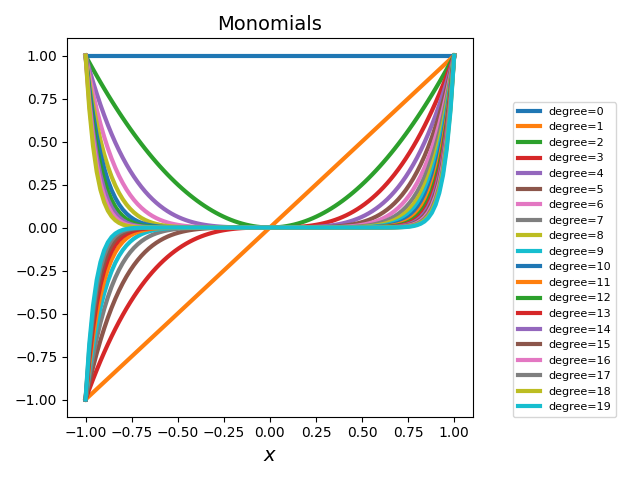

In [10]:
xspace = np.linspace(-1, 1, 100)
def monomial(x, param=5):
    "Parameter is the degree-1 of the monomial"
    return np.array([x**ii for ii in range(param)]).T

plt.close(5)
plt.figure(5)
monomials = monomial(xspace, param=20)
for ii in range(monomials.shape[1]):
    plt.plot(xspace, monomials[:, ii], label='degree={0}'.format(ii), lw=3)
plt.title("Monomials", fontsize=14)
plt.xlabel(r"$x$", fontsize=14)
plt.legend(fontsize=8, loc=(1.1, 0))
plt.tight_layout()
plt.show()

**NEVER USE MONOMIALS.** Doing so will lead to *numerical instabilities* because the vandermonde-like matrix of features will be ill-conditioned. The intuitive reason is that, they lead to redundant features which cause issues with inversion.

Use Orthogonal Polynomials, there are many types
1. Legendre: orthogonal with respect to uniform measure $\int_0^1 \phi_i(x) \phi_j(x) dx  = \delta_{ij}$
2. Chebyshev: orthogonal with respect to beta measure   
3. Hermite: orthogonal with respect to Gaussian measure

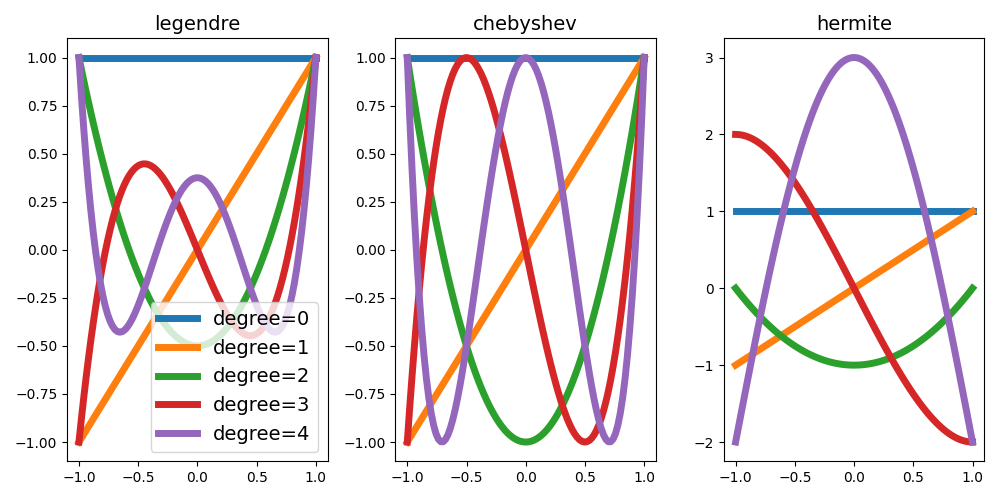

In [11]:
def legendre(x, num_param=5):
    "Legendre polynomials are on [-1,1]"
    return np.polynomial.legendre.legvander(x, num_param-1)

def chebyshev(x, num_param=5):
    "Chebyshev polynomials are on [-1,1]"
    return np.polynomial.chebyshev.chebvander(x, num_param-1)

def hermite(x, num_param=5):
    "Hermite polynomials are on [-inf,inf]"
    return np.polynomial.hermite_e.hermevander(x, num_param-1)

polyoptions = {"legendre":legendre, "chebyshev":chebyshev, "hermite":hermite}

plt.close(6)
fig, axs = plt.subplots(1, len(polyoptions), figsize=(10, 5), num=6)
for ii, (polyname, polyfunc) in enumerate(polyoptions.items()):
    vandermonde = polyfunc(xspace)
    for jj in range(vandermonde.shape[1]):
        axs[ii].plot(xspace, vandermonde[:, jj], label='degree={0}'.format(jj), lw=5)
    if ii == 0:
        axs[ii].legend(fontsize=14)
    axs[ii].set_title(polyname, fontsize=14)
plt.tight_layout()
plt.show()

### Kernel features

A kernel is a symmetric positive definite function. One common kernel has an exponential form

\begin{equation}
K(x, x^{\prime}) = \gamma \exp\left(-\frac{1}{\sigma^2}\lvert x - x^{\prime} \rvert_{\alpha}^{\alpha} \right)
\end{equation}

1. $\gamma$ is a scaling factor, it governs how large this function can become
2. $\sigma^2$ is a distance factor, it governs how fast the function decays with distance between $x^{\prime}$ and $x^{\prime}$
3. $\alpha$: governs how to measure distance

To use these as features you would have to choose some set of points $x_1,\ldots, x_m$ at which to "anchor" these functions so that we have 
\begin{equation}
f(x; \theta) = \sum_{i=1}^m \theta_i K(x, x_i) 
\end{equation}

In [12]:
def exp_kernel(x, xprime, gamma=1, sigma_squared=0.1, alpha=2.0):
    """Exponential kernel"""
    dist = np.array([np.abs(xx-xp)**alpha for xx, xp in zip(x, xprime)])
    in_exp = -dist / sigma_squared
    kern_val = gamma * np.exp(in_exp)
    return kern_val

def kernel_vand(xlocs, gamma=1, sigma_squared=0.1, alpha=2):
    "This funciton build another function that returns a vandermonde matrix."
    def kernel(x, num_param=None):
        #num_param is ignored because it is obtained from xlocs
        A = np.zeros((x.shape[0], xlocs.shape[0]))
        for ii in range(xlocs.shape[0]):
            xtile = xlocs[ii]*np.ones(x.shape)
            A[:, ii] = exp_kernel(x, xtile, gamma=gamma, sigma_squared=sigma_squared, alpha=alpha)
        return A

    return kernel

In [13]:
@interact_manual(ss=(0.001,1.0,0.001), gamma=(1, 10, 1))
def plot_kernel_vand(ss, gamma):
    plt.close(7)
    plt.figure(7, figsize=(7,7))
    nkernels=10
    xkern = np.linspace(-1, 1, nkernels)
    kern_func = kernel_vand(xkern, gamma=gamma, sigma_squared=ss, alpha=2.0)
    kvand = kern_func(xspace)
    for ii in range(kvand.shape[1]):
        plt.plot(xspace, kvand[:, ii], lw=5)
        plt.plot(xkern, np.zeros((nkernels)), 'ko', ms=5)
    plt.xlabel(r"$x$",fontsize=14)
    plt.title("Kernels", fontsize=14)
    plt.show()
#plot_kernel_vand(0.1, 1.0)

interactive(children=(FloatSlider(value=0.5, description='ss', max=1.0, min=0.001, step=0.001), IntSlider(valu…

## Regression of nonlinear functions (but parametric-linear because linear in parameters)

Regression using feature maps is virtually identical to the linear case. We set up the same linear Gaussian system
and plug in the features. In other words the sampling model is now
\begin{equation}
Y = \phi^T(x) \theta + \xi = \sum_{i=1}^m \theta_i \phi_i(x) + \xi 
\end{equation}

So that the linear Gaussian system is virtually identical

\begin{equation}
\begin{bmatrix}
Y_1 \\
Y_2 \\
\vdots \\
Y_N 
\end{bmatrix}
= 
\begin{bmatrix}
\phi^T(x^{(1)}) \\
\phi^T(x^{(2)}) \\
\vdots  \\
\phi^T(x^{(N)}) 
\end{bmatrix}
\theta
+ 
\xi \quad 
\xi \sim \mathcal{N}\left(
\begin{bmatrix}
0 \\
0 \\
\vdots \\
0
\end{bmatrix}
\begin{bmatrix}
\sigma^2 & 0 & \cdots &0 \\
0 & \sigma^2 & \ddots & \vdots \\
0 & \ddots & \ddots & \vdots \\
0 & \cdots & 0 & \sigma^2
\end{bmatrix}
\right)
\end{equation}

We now have $y = A(x) \theta + \xi$. With $A(x)$ being a slightly different **Vandermonde** matrix composed of the feature maps.

Next lets set up a demo problem and check out the performance

Next we set up the "truth" model

In [14]:
def true_function(x):
    return np.exp(-x**2 / 0.1)*np.sin(x) - x**3
    #return x**5 + 0.2*x**6 - x - 0.5
xspace = np.linspace(-1, 1, 1000)
# num_data = 20
num_data = 10
# num_data = 100

noise_rv2 = Gaussian(0.0, 1e-4)
# noise_cov = 1e-2


#XDATA = np.random.rand(NUM_DATA)*2.0 - 1.0 # randomly spaced data
xdata = np.linspace(-1, 1, num_data) # linearly space data
ydata = true_function(xdata) + np.random.randn(num_data) * np.sqrt(noise_rv2.cov)
ytrue = true_function(xspace)

Next we generate predictions with various features

In [18]:
# Legendre Basis
@interact_manual(degree=(0, 20, 1), log_noise_learn=(-10,0,1))
def legendre_infer(degree=1, log_noise_learn=np.log10(noise_rv2.cov)):
    prior_theta = Gaussian(np.zeros((int(degree+1))), np.eye(int(degree+1)))
    noise_var = 10**(log_noise_learn) * np.ones((ydata.shape[0]))

    vand_func = polyoptions["legendre"]
    noise_model = Gaussian(0.0, 10**(log_noise_learn))
    prior_model, post_model, post_pred = linear_regression(xdata, ydata, xspace, lambda x: vand_func(x, num_param=degree+1), prior_theta, noise_model)

    plt.close(8)
    fig, axis = plt.subplots(1, 2, figsize=(10, 5), num=8)
    Apred = vand_func(xspace, num_param=degree+1)
    prior_pred = LinearGaussianModel(Apred, prior_theta, None)
    plot_function_pred(axis[0], prior_pred, xdata, ydata, xspace, ytrue, "Prior", nsample=100, legend=False)
    plot_function_pred(axis[1], post_pred, xdata, ydata, xspace, ytrue, "Posterior", nsample = 100)
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=1, description='degree', max=20), IntSlider(value=-4, description='log_n…

In [19]:
# Kernel Basis
@interact_manual(nkernels=(2,100, 2), log_sigma=(-4,1,0.5), gamma=(0.1, 10.5, 1), log_noise_learn=(-10,0,1))
def kern_infer(nkernels=10, gamma=1, log_sigma=1, log_noise_learn=np.log10(noise_rv2.cov)):
    prior_theta = Gaussian(np.zeros((int(nkernels))), np.eye(int(nkernels)))
    noise_var = 10**(log_noise_learn) * np.ones((ydata.shape[0]))

    xkern = np.linspace(-1, 1, nkernels)
    vand_func = kernel_vand(xkern, gamma=gamma, sigma_squared=10**log_sigma, alpha=2.0)
    noise_model = Gaussian(0.0, 10**(log_noise_learn))
    prior_model, post_model, post_pred = linear_regression(xdata, ydata, xspace, vand_func, prior_theta, noise_model)

    plt.close(9)
    fig, axis = plt.subplots(1, 2, figsize=(10, 5), num=9)
    Apred = vand_func(xspace, num_param=nkernels)
    prior_pred = LinearGaussianModel(Apred, prior_theta, None)
    plot_function_pred(axis[0], prior_pred, xdata, ydata, xspace, ytrue, "Prior", nsample=100, legend=False)
    plot_function_pred(axis[1], post_pred, xdata, ydata, xspace, ytrue, "Posterior", nsample = 100)
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=10, description='nkernels', min=2, step=2), FloatSlider(value=1.0, descr…